In [1]:
import tifffile as tf
import numpy as np
import pandas as pd

import glob
from scipy import spatial
from scipy import ndimage

from importlib import reload

import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt
%matplotlib inline

import arabidopsis_utils as thales
import MinimumBoundingBox as mbb

In [2]:
reload(thales)

<module 'arabidopsis_utils' from '/home/ejam/documents/arabidopsis_scanning/jupyter/arabidopsis_utils.py'>

In [3]:
tiff_file = '../raw3d/Day6_110821_U112-3.tif'
tiff_file = '../raw3d/Day7_110921_U112-3.tif'
tiff_file = '../raw3d/Day7_110921_Col_0_X.tif'
pot_src = '../pots/'

_, fname = os.path.split(tiff_file)
bname = os.path.splitext(fname)[0]

pidx = 3
pname = 'pot{}'.format(pidx)

src = pot_src + bname + '/'
leaf_dst = '../leaves/'
dst = leaf_dst + bname + '/' + pname + '/'

filename = dst + bname + '_'+pname+'_clean.tif'
img = tf.imread(filename)

In [4]:
img, ceros, cerosshape = thales.clean_zeroes(img)

46 % reduction from input


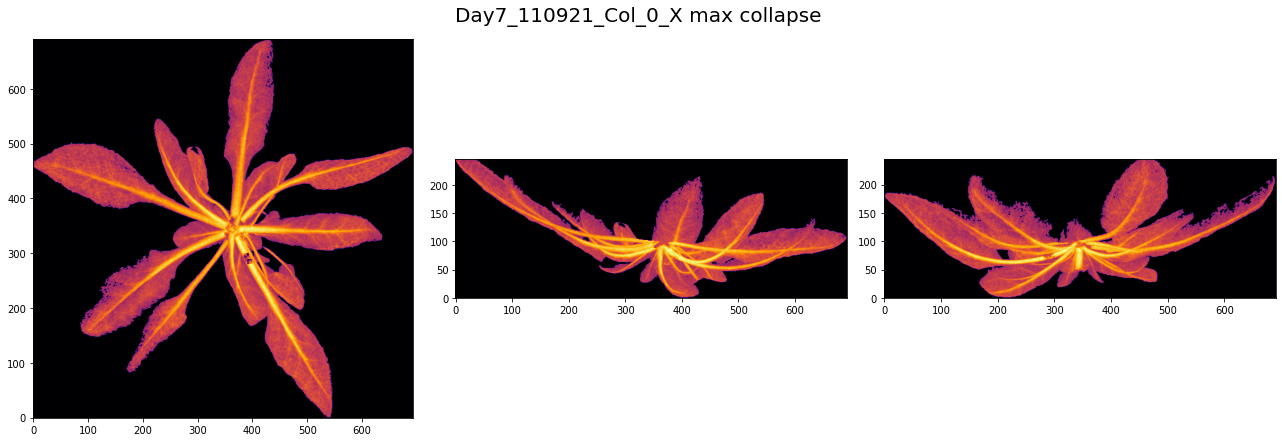

In [5]:
leafcounter = 0
snaps = thales.collapse_dimensions_max(img)
thales.plot_collapse_dimensions(snaps, bname, 'max', display=display, writefig=False, dst=dst);

In [6]:
labels,num = ndimage.label(img, structure=ndimage.generate_binary_structure(img.ndim, 1))
hist,bins = np.histogram(labels, bins=num, range=(1,num+1))
argsort_hist = np.argsort(hist)[::-1]
print(num, hist[argsort_hist][:20])

cutoff = 1e-3
sz_hist = np.sum(hist)

foo = np.atleast_1d(np.asarray(np.nonzero(hist/sz_hist > cutoff)).squeeze())
bar = np.argsort(hist[foo])[::-1]

signif_idx = foo[bar]
print('Large components: ', len(signif_idx))

1 [755469]
Large components:  1


0	100.0


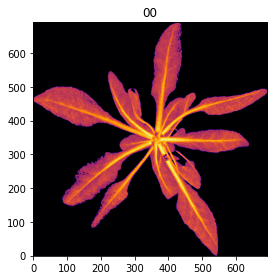

In [7]:
Comps = [None for x in range(len(signif_idx))]
for i in range(len(signif_idx)):
    idx = signif_idx[i]
    mask = labels==idx+1
    box = img.copy()
    box[~mask] = 0
    
    if len(signif_idx) > 1 :
        filename = dst + bname + '_{}_leaf{:02d}.tif'.format(pidx, leafcounter) 
        tf.imwrite(filename, box, photometric='minisblack',compress=3)
        leafcounter += 1

    snaps = thales.collapse_dimensions_max(box)
    Comps[i] = snaps
    print(i, np.around(100*hist[idx]/sz_hist, 3), sep='\t')
    
fig, ax = plt.subplots(1,len(signif_idx), figsize=(16,4), sharex=True, sharey=True)
ax = np.atleast_1d(ax)
for i,a in enumerate(ax.ravel()):
    a.imshow(Comps[i][0], origin='lower', cmap='inferno')
    a.set_title('{:02d}'.format(i))

fig.tight_layout();

In [8]:
idx = signif_idx[0]
mask = labels == idx+1
box0 = img.copy()
box0[~mask] = 0

snaps = thales.collapse_dimensions_max(box0)

In [9]:
#petioles = img.copy()
petioles = box0.copy()
petioles[petioles < 140] = 0
#petioles = ndimage.grey_closing(petioles, size=(25,25,25))
#petioles = ndimage.grey_erosion(petioles, size=(3,3,3))
petioles = ndimage.grey_erosion(petioles, size=(5,5,5))

pcoords = np.asarray(np.nonzero(petioles))
centerby = np.mean(pcoords, axis=1)# + np.asarray([0,-10,10])
cpcoords = pcoords - centerby.reshape(-1, 1)
pcenter = centerby.astype(int) 

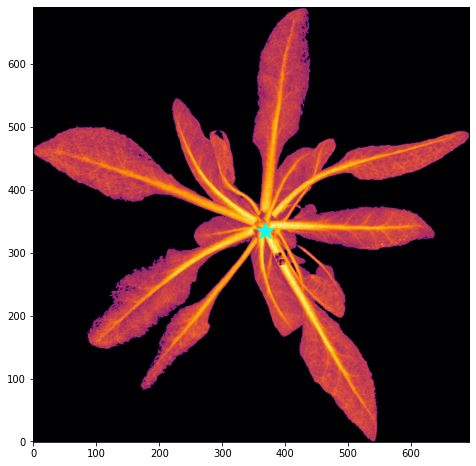

In [10]:
plt.figure(figsize=(8,8))

plt.imshow(snaps[0], cmap='inferno', origin='lower')
plt.scatter(pcenter[2], pcenter[1], s=300, c='cyan', marker='*');

In [11]:
acoords = np.asarray(np.nonzero(box0))
cpcoords = acoords - centerby.reshape(-1, 1)

In [12]:
norms = np.sqrt(np.sum(cpcoords**2, axis=0))
#norms = np.sqrt(cpcoords[1]**2 + cpcoords[2]**2)
out_mask = norms > 30
out_coords = acoords[:, out_mask]
core_coords = acoords[:, ~out_mask]

mask = np.empty_like(petioles)
mask[tuple(out_coords)] = True
plant_tips = mask*box0

mask = np.empty_like(petioles)
mask[tuple(core_coords)] = True
plant_core = mask*box0

In [13]:
tsnaps = thales.collapse_dimensions_max(plant_tips)
csnaps = thales.collapse_dimensions_max(plant_core)

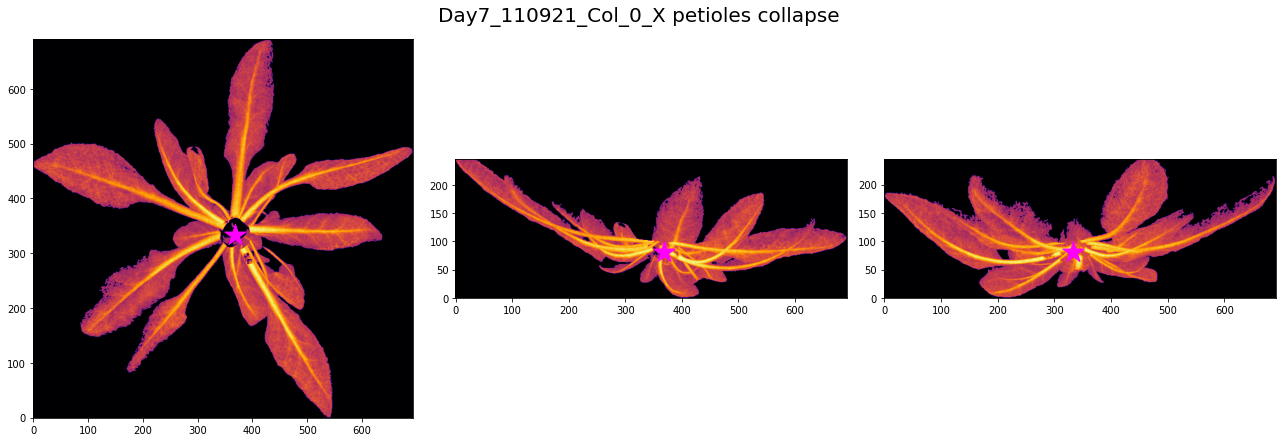

In [14]:
fig, ax = thales.plot_collapse_dimensions(tsnaps, bname, 'petioles', display=display, writefig=False, dst=dst)
ax[0].scatter(pcenter[2], pcenter[1], s=500, c='magenta', marker='*')
ax[1].scatter(pcenter[2], pcenter[0], s=500, c='magenta', marker='*')
ax[2].scatter(pcenter[1], pcenter[0], s=500, c='magenta', marker='*');

In [15]:
labels,num = ndimage.label(plant_tips, structure=ndimage.generate_binary_structure(img.ndim, 1))
hist,bins = np.histogram(labels, bins=num, range=(1,num+1))
argsort_hist = np.argsort(hist)[::-1]
print(num, hist[argsort_hist][:20])

cutoff = 5e-3
sz_hist = np.sum(hist)

foo = np.atleast_1d(np.asarray(np.nonzero(hist/sz_hist > cutoff)).squeeze())
bar = np.argsort(hist[foo])[::-1]
signif_idx = foo[bar]
print('Large components: ', len(signif_idx))

Comps = [None for x in range(len(signif_idx))]
leafcounter = 0
for i in range(len(signif_idx)):
    idx = signif_idx[i]
    mask = labels==idx+1
    box = plant_tips.copy()
    box[~mask] = 0
    
    snaps = thales.collapse_dimensions_max(box)
    Comps[i] = snaps
    print(i, idx, np.around(100*hist[idx]/sz_hist, 3), sep='\t')

19 [257252 251526 107772  68496  33893   3948   3005    377    151      3
      2      1      1      1      1      1      1      1      1]
Large components:  6
0	5	35.413
1	0	34.625
2	3	14.836
3	8	9.429
4	13	4.666
5	1	0.543


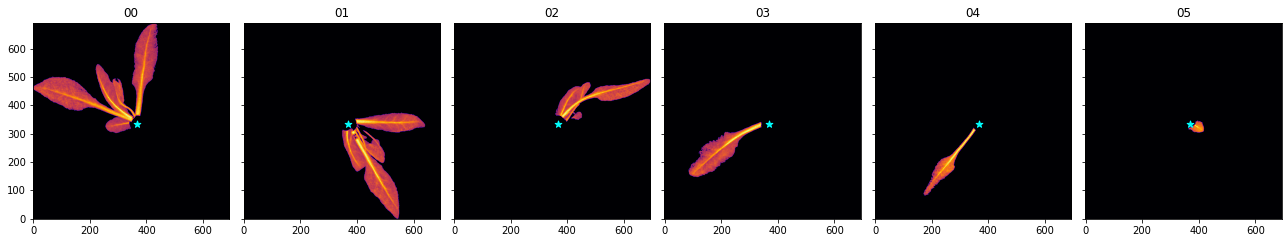

In [16]:
fig, ax = plt.subplots(1,len(signif_idx), figsize=(18,10), sharex=True, sharey=True)

for i,a in enumerate(ax.ravel()):
    a.imshow(Comps[i][0], origin='lower', cmap='inferno')#, vmax=1)
    a.set_title('{:02d}'.format(i))
    a.scatter(pcenter[2], pcenter[1], s=50, c='cyan', marker='*');

fig.tight_layout();

## IFT (Run 1)

In [17]:
markers = np.copy(box0).astype(int)
markers[markers == 0] = -1
markers[markers > 0] = 0

idx = 1
for mark in signif_idx +1:
    markers[labels == mark] = idx
    idx += 1
    
ift = ndimage.watershed_ift(box0, markers)

In [18]:
Leaves = [None for x in range(len(signif_idx))]
for i in range(len(signif_idx)):
    mask = ift == i+1
    box = img.copy()
    box[~mask] = 0
    
    tsnap = thales.collapse_dimensions_max(box)
    Leaves[i] = tsnap[0]

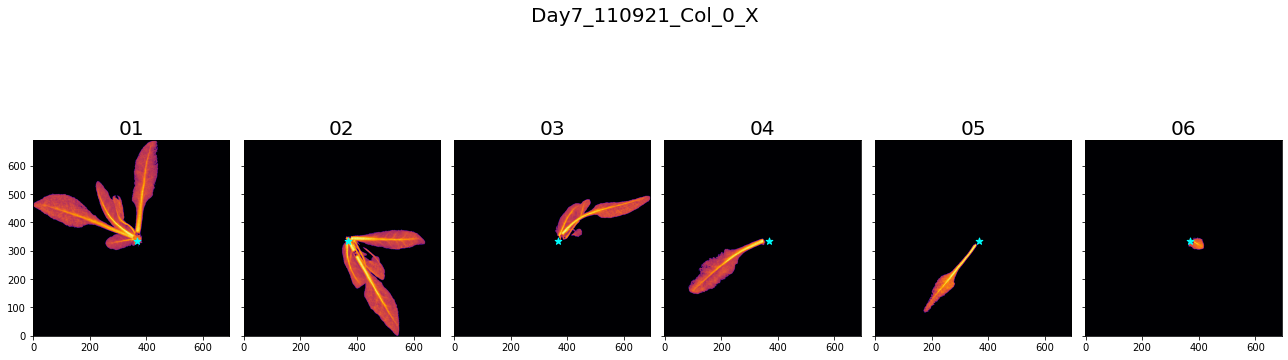

In [19]:
fig, ax = plt.subplots(1,len(signif_idx), figsize=(18,10), sharex=True, sharey=True)

for i,a in enumerate(ax.ravel()):
    a.imshow(Leaves[i], origin='lower', cmap='inferno')
    a.set_title('{:02d}'.format(i+1), fontsize=20)
    a.scatter(pcenter[2], pcenter[1], s=50, c='cyan', marker='*');

fig.suptitle(bname, fontsize=20, y=0.8)
fig.tight_layout();

filename = dst + bname + '_ift_segmentation.jpg'
#plt.savefig(filename, format='jpg', dpi=96, bbox_inches='tight', pil_kwargs={'optimize':True})

In [23]:
for i in range(len(signif_idx)):
    mask = ift == i+1
    box = img.copy()
    box[~mask] = 0
    
    filename = dst + bname + '_{}_leaf{:02d}.tif'.format(pidx, leafcounter) 
    tf.imwrite(filename, box, photometric='minisblack',compress=3)
    leafcounter += 1

In [24]:
print(filename)

../leaves/Day7_110921_Col_0_X/pot3/Day7_110921_Col_0_X_3_leaf05.tif


## IFT Run 2

In [89]:
iftidx = 3
mask = ift == iftidx
#box1 = box0.copy()
box1 = plant_tips.copy()
box1[~mask] = 0

96 % reduction from input


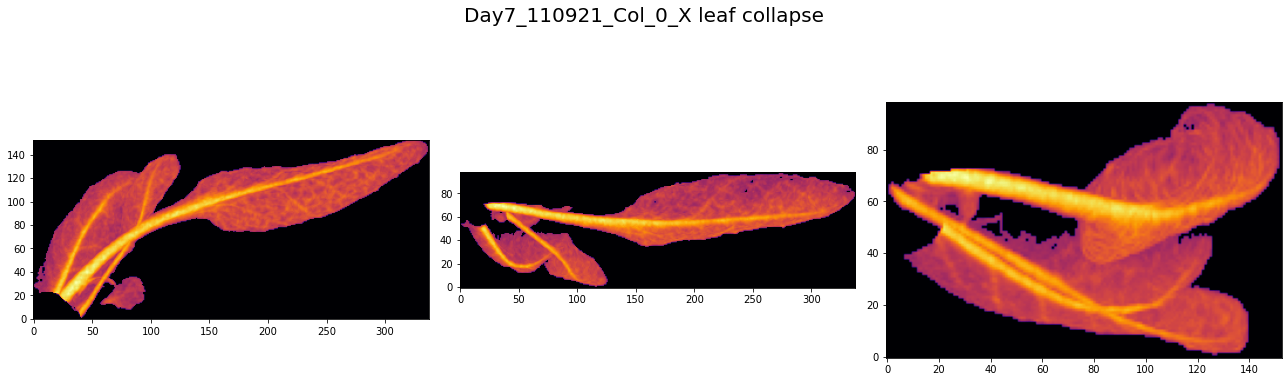

In [90]:
foo = box1.copy()
foo, _, _ = thales.clean_zeroes(foo)

tsnap = thales.collapse_dimensions_max(foo)
thales.plot_collapse_dimensions(tsnap, bname, 'leaf', display=display, writefig=False, dst=dst);

In [95]:
bar = box1.copy()
bar[bar < 105] = 0

labels,num = ndimage.label(bar, structure=ndimage.generate_binary_structure(img.ndim, 1))
hist,bins = np.histogram(labels, bins=num, range=(1,num+1))
argsort_hist = np.argsort(hist)[::-1]
print(num, hist[argsort_hist][:20])
sz_hist = np.sum(hist)

cutoff = 1e-2
foo = np.atleast_1d(np.asarray(np.nonzero(hist/sz_hist > cutoff)).squeeze())
bar = np.argsort(hist[foo])[::-1]

signif_idx = foo[bar]
print('Large components: ', len(signif_idx))

391 [30898  6313  5093   132   127    66    59    49    40    40    37    33
    31    25    21    20    17    17    16    15]
Large components:  3


0	196	70.288
1	0	14.361
2	8	11.586


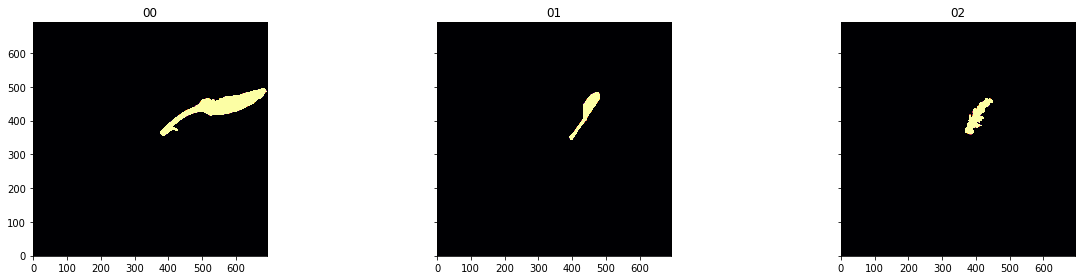

In [96]:
Comps = [None for x in range(len(signif_idx))]

for i in range(len(signif_idx)):
    idx = signif_idx[i]
    mask = labels==idx+1
    box = box1.copy()
    box[~mask] = 0

    snaps = thales.collapse_dimensions_max(box)
    Comps[i] = snaps
    
    print(i, idx, np.around(100*hist[idx]/sz_hist, 3), sep='\t')
    
fig, ax = plt.subplots(1,len(signif_idx), figsize=(18,4), sharex=True, sharey=True)

for i,a in enumerate(ax.ravel()):
    a.imshow(Comps[i][0], origin='lower', cmap='inferno', vmax=1)
    a.set_title('{:02d}'.format(i))

fig.tight_layout();

In [97]:
mask = ift == iftidx
box2 = box0.copy()
box2[~mask] = 0

markers = np.copy(box2).astype(int)
markers[markers == 0] = -1
markers[markers > 0] = 0

idx = 1
for mark in signif_idx + 1:
    markers[labels == mark] = idx
    idx += 1
    
ift1 = ndimage.watershed_ift(box2, markers)

In [98]:
Leaves = [None for x in range(len(signif_idx))]
for idx in range(len(signif_idx)):
    mask = ift1 == idx+1
    box = img.copy()
    box[~mask] = 0
    
    tsnap = thales.collapse_dimensions_max(box)
    Leaves[idx] = tsnap[0]

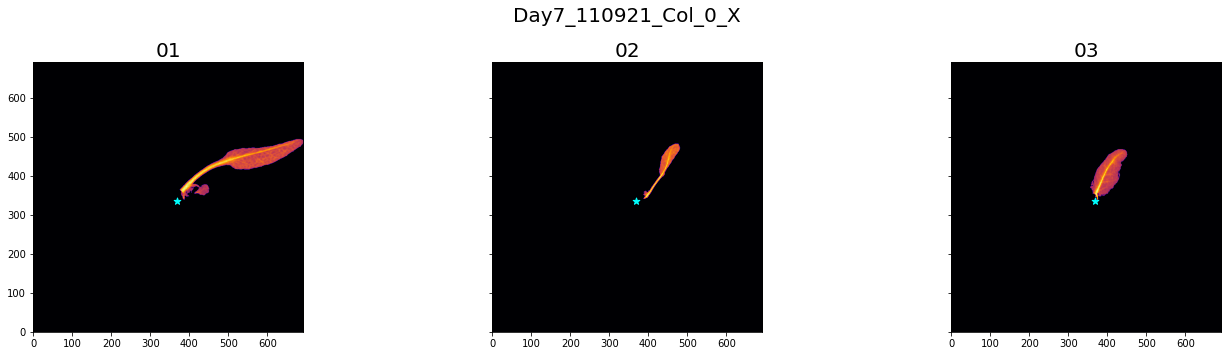

In [99]:
fig, ax = plt.subplots(1,len(signif_idx), figsize=(20,5), sharex=True, sharey=True)

for i,a in enumerate(ax.ravel()):
    a.imshow(Leaves[i], origin='lower', cmap='inferno')
    a.set_title('{:02d}'.format(i+1), fontsize=20)
    a.scatter(pcenter[2], pcenter[1], s=50, c='cyan', marker='*');

fig.suptitle(bname, fontsize=20)
fig.tight_layout();

In [100]:
for idx in range(len(signif_idx)):
    mask = ift1 == idx+1
    box = img.copy()
    box[~mask] = 0
    
    filename = dst + bname + '_{}_leaf{:02d}.tif'.format(pidx, leafcounter) 
    tf.imwrite(filename, box, photometric='minisblack',compress=3)
    leafcounter += 1

## IFT (run 3)

93 % reduction from input


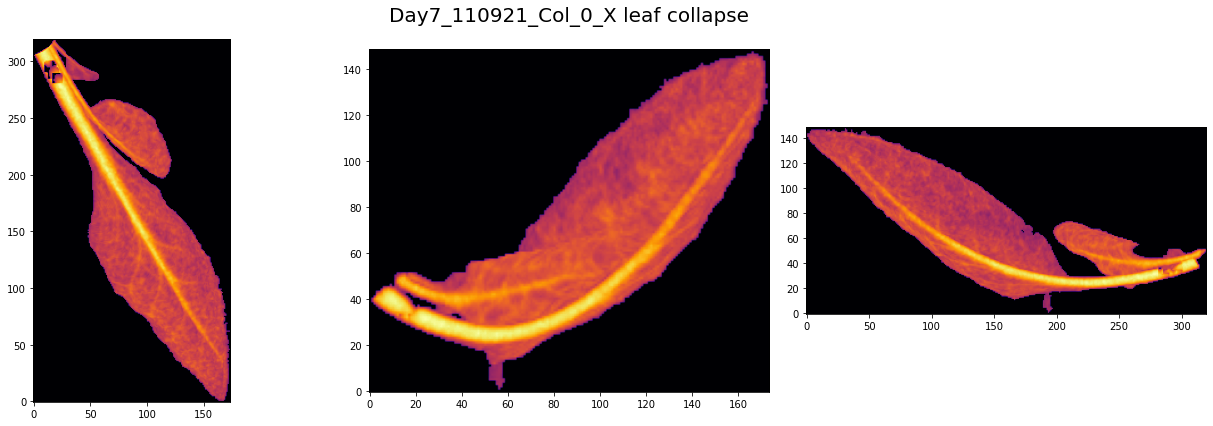

In [69]:
iftidx = 1
mask = ift1 == iftidx
#box1 = box0.copy()
box1 = plant_tips.copy()
box1[~mask] = 0

foo = box1.copy()
foo, _, _ = thales.clean_zeroes(foo)

tsnap = thales.collapse_dimensions_max(foo)
thales.plot_collapse_dimensions(tsnap, bname, 'leaf', display=display, writefig=False, dst=dst);

In [82]:
bar = box1.copy()
bar[bar < 118] = 0
#bar = ndimage.grey_closing(bar, size=(9,9,9))

labels,num = ndimage.label(bar, structure=ndimage.generate_binary_structure(img.ndim, 1))
hist,bins = np.histogram(labels, bins=num, range=(1,num+1))
argsort_hist = np.argsort(hist)[::-1]
print(num, hist[argsort_hist][:20])
sz_hist = np.sum(hist)

cutoff = 5e-2
foo = np.atleast_1d(np.asarray(np.nonzero(hist/sz_hist > cutoff)).squeeze())
bar = np.argsort(hist[foo])[::-1]

signif_idx = foo[bar]
print('Large components: ', len(signif_idx))

500 [21667  5257   471   350    88    82    64    64    58    55    55    54
    49    43    42    39    38    35    35    34]
Large components:  2


0	17	71.638
1	38	17.381


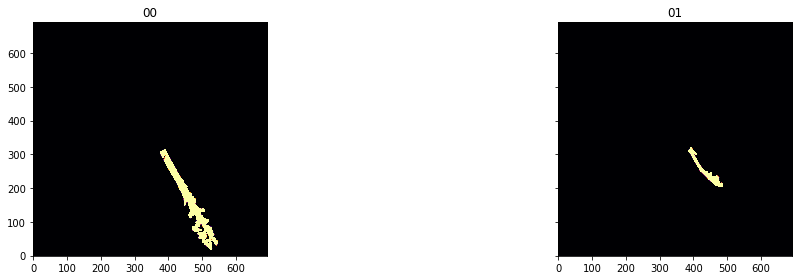

In [83]:
Comps = [None for x in range(len(signif_idx))]

for i in range(len(signif_idx)):
    idx = signif_idx[i]
    mask = labels==idx+1
    box = box1.copy()
    box[~mask] = 0

    snaps = thales.collapse_dimensions_max(box)
    Comps[i] = snaps
    
    print(i, idx, np.around(100*hist[idx]/sz_hist, 3), sep='\t')
    
fig, ax = plt.subplots(1,len(signif_idx), figsize=(18,4), sharex=True, sharey=True)
ax = np.atleast_1d(ax)
for i,a in enumerate(ax.ravel()):
    a.imshow(Comps[i][0], origin='lower', cmap='inferno', vmax=1)
    a.set_title('{:02d}'.format(i))

fig.tight_layout();

In [84]:
mask = ift1 == iftidx
box2 = box0.copy()
box2[~mask] = 0

markers = np.copy(box2).astype(int)
markers[markers == 0] = -1
markers[markers > 0] = 0

idx = 1
for mark in signif_idx +1:# + [10,11,13,16,18]] + 1:
    markers[labels == mark] = idx
    idx += 1
    
ift2 = ndimage.watershed_ift(box2, markers)

In [85]:
Leaves = [None for x in range(len(signif_idx))]
for idx in range(len(signif_idx)):
    mask = ift2 == idx+1
    box = img.copy()
    box[~mask] = 0
    
    tsnap = thales.collapse_dimensions_max(box)
    Leaves[idx] = tsnap[0]

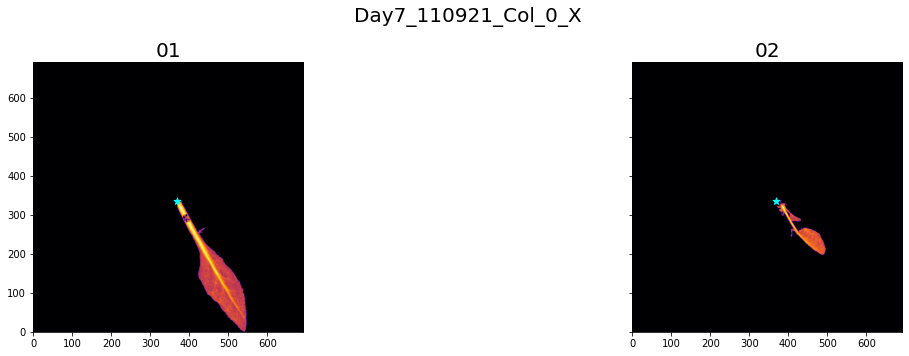

In [86]:
fig, ax = plt.subplots(1,len(signif_idx), figsize=(20,5), sharex=True, sharey=True)

for i,a in enumerate(ax.ravel()):
    a.imshow(Leaves[i], origin='lower', cmap='inferno')
    a.set_title('{:02d}'.format(i+1), fontsize=20)
    a.scatter(pcenter[2], pcenter[1], s=50, c='cyan', marker='*');

fig.suptitle(bname, fontsize=20)
fig.tight_layout();

In [87]:
for idx in range(len(signif_idx)):
    mask = ift2 == idx+1
    box = img.copy()
    box[~mask] = 0
    
    filename = dst + bname + '_{}_leaf{:02d}.tif'.format(pidx, leafcounter) 
    tf.imwrite(filename, box, photometric='minisblack',compress=3)
    leafcounter += 1

In [101]:
filename

'../leaves/Day7_110921_Col_0_X/pot3/Day7_110921_Col_0_X_3_leaf24.tif'